In [14]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.datasets import mnist
from tensorflow import keras
from tensorflow.keras import layers
import pickle
import os
import shutil
from tensorflow.keras.utils import image_dataset_from_directory
from tensorflow.keras.preprocessing import image
import os
import numpy as np
from keras.preprocessing.image import ImageDataGenerator
from keras import models
from keras import layers
from keras.preprocessing.image import ImageDataGenerator
from keras import optimizers
import matplotlib.pyplot as plt


from keras.applications import VGG16

In [15]:
#tumordata = "archive/training"
#data_from_kaggle_test = "data-from-kaggle/test1"
#data_dirname = "tumordetection"

In [16]:
def make_dataset(subset_name, start_idx, end_idx):
    for category in { "tr-no", "tumor" }:
        # data_dirname/subset_name/categoroy 
        dir = f"{data_dirname}/{subset_name}/{category}"
        # print(dir)
        os.makedirs(dir)
        fnames = [f"{category}.{i}.jpg" for i in range(start_idx, end_idx)]
        # print(fnames)
        for fname in fnames: 
                shutil.copyfile(src=f"{tumordata}/{fname}", dst=f"{dir}/{fname}") 


In [17]:
base_dir = "tumordata"
train_dir = os.path.join(base_dir, 'Training')
validation_dir = os.path.join(base_dir, 'Validation')
test_dir = os.path.join(base_dir, 'Testing')
datagen = ImageDataGenerator(rescale=1./255)

In [18]:
conv_base = VGG16(weights='imagenet',
        include_top=False,
        input_shape=(256, 256, 3))

In [19]:
batch_size = 20

In [20]:
def extract_features(directory, sample_count):
    features = np.zeros(shape=(sample_count, 5, 5, 512))
    labels = np.zeros(shape=(sample_count))
    generator = datagen.flow_from_directory(
    directory,
    target_size=(256, 256),
    batch_size= batch_size,
    class_mode='categorical')
    i=0
    for inputs_batch, labels_batch in generator:
        features_batch = conv_base.predict(inputs_batch)
        features[i * batch_size : (i + 1) * batch_size] = features_batch
        labels[i * batch_size : (i + 1) * batch_size] = labels_batch
        i += 1
        if i * batch_size >= sample_count:
            break
    return features, labels

In [21]:
#train_features, train_labels = extract_features(train_dir, 1000)
#validation_features, validation_labels = extract_features(validation_dir, 10)
#test_features, test_labels = extract_features(test_dir, 1000)


#train_features = np.reshape(train_features, (1000, 5*5* 512))
#validation_features = np.reshape(validation_features, (10, 5*5* 512))
#test_features = np.reshape(test_features, (1000, 5*5* 512))


In [22]:
def build_model():
        conv_base = VGG16(weights='imagenet',
                include_top=False,
                input_shape=(256, 256, 3))
        conv_base.trainable = False
        model = models.Sequential()
        model.add(conv_base)
        model.add(layers.GlobalAveragePooling2D())
        model.add(layers.Dense(1024,activation='relu'))
        model.add(layers.Dense(1024,activation='relu'))
        model.add(layers.Dense(512, activation='relu'))
        model.add(layers.Dropout(0.2))
        model.add(layers.Dense(4, activation='softmax'))
   
        return model

In [23]:
mode = build_model()

In [24]:
mode.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 8, 8, 512)         14714688  
                                                                 
 global_average_pooling2d_1  (None, 512)               0         
  (GlobalAveragePooling2D)                                       
                                                                 
 dense_4 (Dense)             (None, 1024)              525312    
                                                                 
 dense_5 (Dense)             (None, 1024)              1049600   
                                                                 
 dense_6 (Dense)             (None, 512)               524800    
                                                                 
 dropout_1 (Dropout)         (None, 512)               0         
                                                      

In [25]:
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import optimizers
from tensorflow.keras.models import load_model

def fit20(model):
    train_dir = os.path.join(base_dir, 'Training')
    batch_size = 20

    train_datagen = ImageDataGenerator(
        rescale=1./255,
        rotation_range=40,
        width_shift_range=0.2,
        height_shift_range=0.2,
        shear_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True,
        fill_mode='nearest',
        #validation_split=0.2  # 20% of the training data will be used for validation
    )

    train_generator = train_datagen.flow_from_directory(
        train_dir,
        target_size=(256, 256),
        batch_size=batch_size,
        class_mode='categorical',
        #subset='training'  # Use the training subset of the data
    )

    validation_generator = train_datagen.flow_from_directory(
        validation_dir,
        target_size=(256, 256),
        batch_size=batch_size,
        class_mode='categorical',
        #subset='validation'  # Use the validation subset of the data
    )

    model.compile(
        optimizer='adam',  # Using Adam optimizer
        loss='CategoricalCrossentropy',
        metrics=['CategoricalAccuracy']
    )
    callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=10)
    

    history = model.fit(
        train_generator,
        steps_per_epoch=100,
        epochs=100,
        validation_data=validation_generator,
        validation_steps=50,
        callbacks=[callback]
    )

    model.save("Omar_Rabbah_MultiClass")

    # Plotting the training and validation metrics
    acc = history.history['categorical_accuracy'] 
    val_acc = history.history['val_categorical_accuracy']  
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    epochs = range(1, len(acc) + 1)

    # Plotting accuracy
    plt.plot(epochs, acc, 'bo', label='Training acc')
    plt.plot(epochs, val_acc, 'b', label='Validation acc')
    plt.title('Training and validation accuracy')
    plt.legend()
    plt.show()  

    # Plotting loss
    plt.figure()
    plt.plot(epochs, loss, 'bo', label='Training loss')
    plt.plot(epochs, val_loss, 'b', label='Validation loss')
    plt.title('Training and validation loss')
    plt.legend()
    plt.show()  




Found 4604 images belonging to 4 classes.
Found 1108 images belonging to 4 classes.
Epoch 1/3
1/1 [==============================] - 34s 34s/step - loss: 1.3802 - categorical_accuracy: 0.3000 - val_loss: 2.2170 - val_categorical_accuracy: 0.2000
Epoch 2/3
1/1 [==============================] - 31s 31s/step - loss: 1.9447 - categorical_accuracy: 0.2500 - val_loss: 1.7464 - val_categorical_accuracy: 0.2000
Epoch 3/3
1/1 [==============================] - 31s 31s/step - loss: 1.7845 - categorical_accuracy: 0.2000 - val_loss: 1.3182 - val_categorical_accuracy: 0.3000
INFO:tensorflow:Assets written to: Omar_Rabbah_MultiClass\assets


INFO:tensorflow:Assets written to: Omar_Rabbah_MultiClass\assets


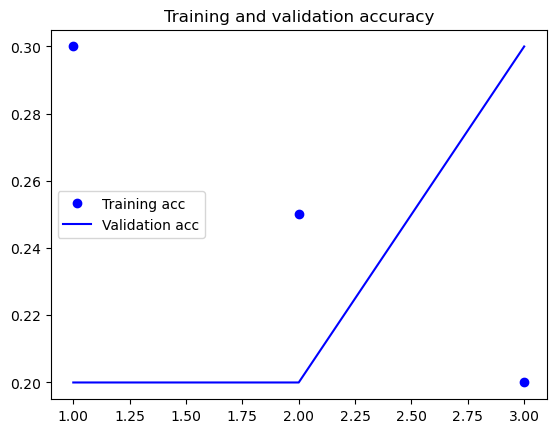

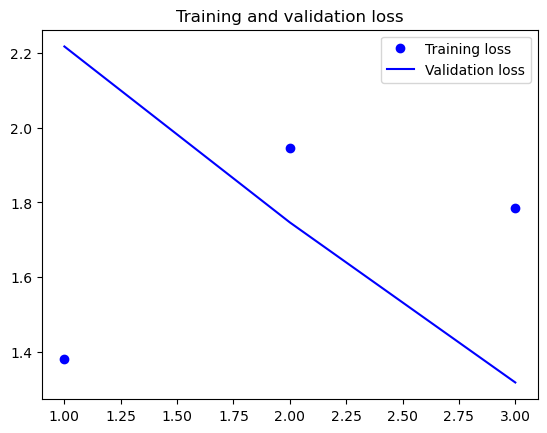

In [26]:


fit20(mode)